# Reproduce Paper Figures
This notebook reproduces the figures from [A factor model of multilayer networks](https://arxiv.org/abs/2206.01804). Each section is labeled with a figure number but limited description of the code is provided. For a more in-depth tutorial, see the `NNTuck_Tutorial.ipynb` notebook.

In [14]:
import NNTucktools  #this .py file contains function definitions for non_negative_tucker with KL loss,
                    # as well as for MULTITENSOR's EM updates
import numpy as np
from NNTucktools import non_negative_tucker, KL_D, max_like, GenerateSBM
import tensorly as tl
from sklearn.metrics import roc_auc_score
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.base import unfold
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from matplotlib.ticker import MaxNLocator

In [22]:
data_path = 'GitHub_Files/'

## Figure 5
We reproduce the results of the methods for interpreting Yˆ in the NNTuck of the first and second synthetic network described above as well as for the 48th village from the Banerjee et. al (2019) work.

In [16]:
N = 200; L = 4; C = 2; K = 2;
alpha = 1; beta = 0;
gamma = 0; eta = 1
G_1 = np.array([[0.2, 0.01],[0.3, 0.1]])
G_3 = np.array([[0.01, 0.2],[0.1, 0]])
G_2 = alpha * G_1 + beta * G_3
G_4 = gamma * G_1 + eta * G_3
G = np.array([G_1, G_2, G_3, G_4])
G_p = np.array([G_1, G_2])
Y = np.array([[1, 0], [0, 1], [alpha, beta], [gamma, eta]])
U = np.zeros((N, 2));
U[:int(N/2), 0] = 1; U[int(N/2):, 1] = 1;
A = np.zeros((L, N, N))
for ell in range(L):
    A[ell, :, :] = GenerateSBM(N, U, G[ell, :, :] ,'mm', U, undirected =  False, Poisson = True, unweighted = True)
NUM_IT = 20
tuck, logl, kld = non_negative_tucker(A, rank = [C, K, K], init='random', n_iter_max=1000,
                                                         symmetric = False, masked = False, 
                                                  MT_stopping_conditions = True, returnErrors = True,
                                                    verbose=False, constrained=False, loss = 'KL', tol=10e-6)
max_logl = logl[-1]
max_tuck = tuck
max_kld = kld[-1]
for i in range(20):
    tuck, logl, kld = non_negative_tucker(A, rank = [C, K, K], init='random', n_iter_max=1000,
                                                         symmetric = False, masked = False, 
                                                  MT_stopping_conditions = True, returnErrors = True,
                                                    verbose=False, constrained=False, loss = 'KL', tol=10e-6)
    if logl[-1] > max_logl:
        max_logl = logl[-1]
        max_tuck = tuck
        max_kld = kld[-1]
core, factors = max_tuck
Y_star = np.zeros_like(factors[0])
r_star = [0, 2]; r_bar = [1, 3]
Y_rstar = factors[0][r_star, :]
Y_rbar = factors[0][r_bar, :]
Y_star[r_star, :] = np.eye(C)
Y_star[r_bar, :] = np.linalg.solve(Y_rstar.T, Y_rbar.T).T
with np.printoptions(precision = 5, suppress=True):
    print("True Y is ")
    print("")
    print(factors[0])
    print("")
    print("Y_norm is")
    print("")
    print(factors[0]/np.sum(factors[0], axis = 1, keepdims = True))
    print("")
    print("Y_star is")
    print("")
    print(Y_star)
#print(factors[0]/factors[0][0])

True Y is 

[[0.23861 0.00005]
 [0.24082 0.00003]
 [0.00001 0.23056]
 [0.      0.23066]]

Y_norm is

[[0.9998  0.0002 ]
 [0.99987 0.00013]
 [0.00004 0.99996]
 [0.00001 0.99999]]

Y_star is

[[ 1.       0.     ]
 [ 1.00925 -0.00007]
 [ 0.       1.     ]
 [-0.00003  1.0004 ]]


True Y is 

[[0.00419 0.00153]
 [0.00414 0.00121]
 [0.0051  0.00082]
 [0.00486 0.00231]
 [0.00118 0.00521]
 [0.00071 0.00511]
 [0.00164 0.00081]]

Y_norm is

[[0.73243 0.26757]
 [0.77323 0.22677]
 [0.86114 0.13886]
 [0.67733 0.32267]
 [0.18457 0.81543]
 [0.12268 0.87732]
 [0.66946 0.33054]]

row normalized Y_star is

[[-0.04163  0.95837]
 [-0.06287  0.93713]
 [-0.09843  0.90157]
 [-0.00593  0.99407]
 [ 0.76718  0.23282]
 [ 1.       0.     ]
 [ 0.       1.     ]]



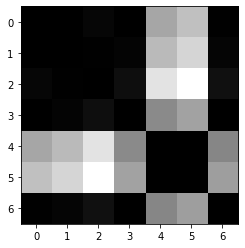

In [23]:
max_tuck = np.load(data_path + 'g_48_tuck.npy', allow_pickle = True)
gv21_core, gv21_factors = max_tuck
Y_v21 = gv21_factors[0]
Y_star = np.zeros_like(Y_v21)
r_star = [5, 6]; r_bar = [r for r in range(7) if r not in r_star]
Y_rstar = Y_v21[r_star, :]
Y_rbar = Y_v21[r_bar, :]
Y_star[r_star, :] = np.eye(C)
Y_star[r_bar, :] = np.linalg.solve(Y_rstar.T, Y_rbar.T).T
Y_2norm = Y_v21/np.linalg.norm(Y_v21, axis = 1, keepdims = True)
plt.imshow(Y_2norm@Y_2norm.T, cmap = 'binary')
with np.printoptions(precision = 5, suppress=True):
    print("True Y is ")
    print("")
    print(Y_v21)
    print("")
    print("Y_norm is")
    print("")
    print(Y_v21/np.sum(Y_v21, axis = 1, keepdims = True))
    print("")
    print("row normalized Y_star is")
    print("")
    print(Y_star/np.sum(abs(Y_star), axis = 1, keepdims = True))
    print("")


## Figure 6
NNTuck performance on independent (left) and tubular (right) link prediction tasks with varying latent dimensions K and C for Krackhardt’s CSS multilayer network.

Text(0.5, 1.0, 'Krackhardt test AUC for independent fivefold cross-validation')

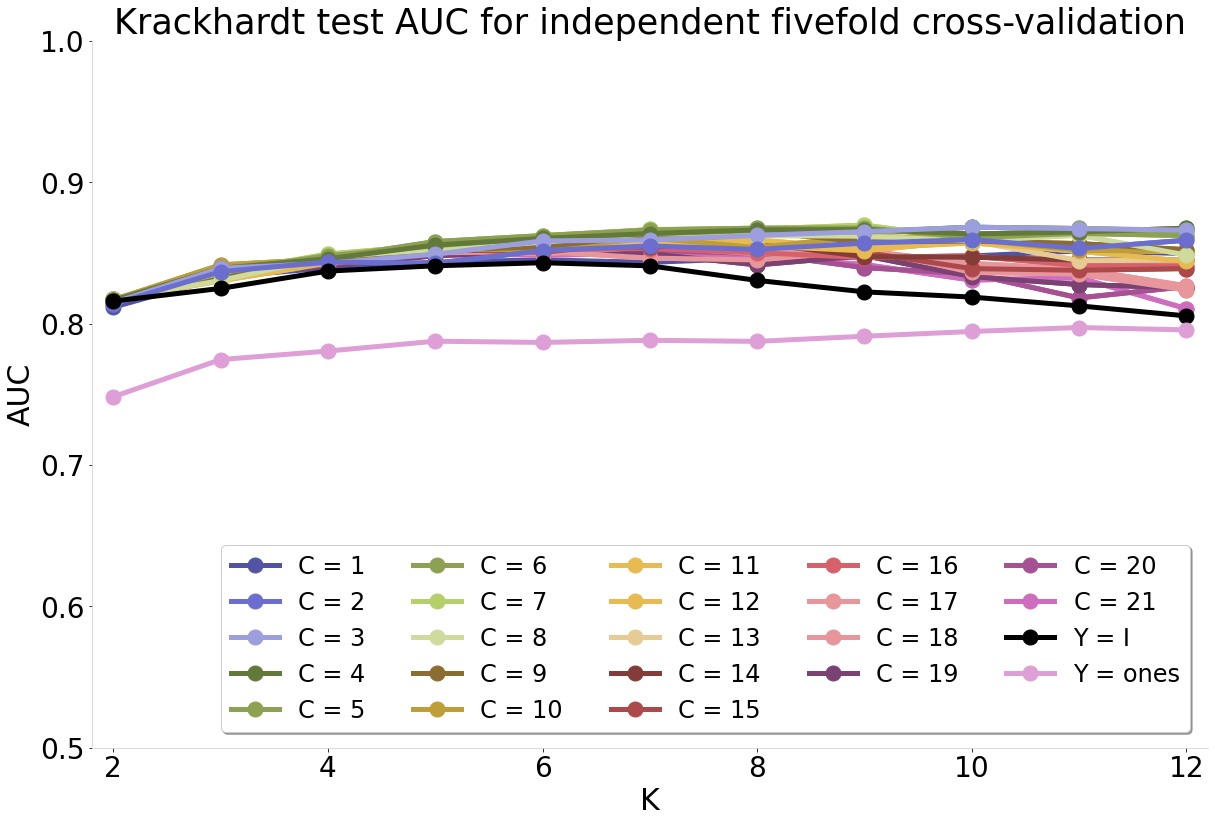

In [24]:
krack = np.load(data_path +'krack.npy')
avg_AUCs_krack_chunk = np.load(data_path +'avg_AUCs_krack_chunk.npy')
avg_KL_krack_chunk = np.load(data_path +'avg_KL_krack_chunk.npy')
avg_AUCs_krack_train_chunk = np.load(data_path +'avg_AUCs_krack_train_chunk.npy')
avg_KL_krack_train_chunk = np.load(data_path +'avg_KL_krack_train_chunk.npy')
avg_AUCs_krack_iid = np.load(data_path +'avg_AUCs_krack_iid.npy')
avg_AUCs_krack_train_iid = np.load(data_path +'avg_AUCs_krack_train_iid.npy')
avg_krack_ones_AUC_chunk = np.load(data_path +'avg_krack_ones_AUC_chunk.npy')
avg_krack_ones_KL_chunk = np.load(data_path +'avg_krack_ones_KL_chunk.npy')
avg_krack_ones_AUC_train_chunk = np.load(data_path +'avg_krack_ones_AUC_train_chunk.npy')
avg_krack_ones_KL_train_chunk = np.load(data_path +'avg_krack_ones_KL_train_chunk.npy')
avg_krack_ones_AUC = np.load(data_path +'avg_krack_ones_AUC.npy')
avg_krack_ones_KL = np.load(data_path +'avg_krack_ones_KL.npy')
avg_krack_ones_AUC_train = np.load(data_path +'avg_krack_ones_AUC_train.npy')
avg_krack_ones_KL_train = np.load(data_path +'avg_krack_ones_KL_train.npy')
c_list = [1, 3, 6, 9, 12]
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.tab20b #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 25)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
for ell in range(2, 23):
    col = colors[ell]
    axis.plot(range(2,13),avg_AUCs_krack_iid[:, ell-1], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell-1]))
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)

for ell in range(22,2, -1):
    col = colors[ell]
    axis.plot(range(2,13),avg_AUCs_krack_iid[:, ell-1], lw = 5, marker='o', markersize= 15, c=col)
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)
axis.plot(range(2,13),avg_AUCs_krack_iid[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

    
axis.set_ylim(0.5, 1)
axis.set_xlim(1.8, 12.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,13), avg_krack_ones_AUC, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')
axis.legend(fontsize = 24, loc='lower center', bbox_to_anchor=(0.55, .005),
          ncol=5, fancybox=True, shadow=True)
axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Krackhardt test AUC for independent fivefold cross-validation',fontsize=35)
#plt.savefig('krack_iid_sweep.pdf', pad_inches=0.05)

Text(0.5, 1.0, 'Krackhardt test AUC for tubular fivefold cross-validation')

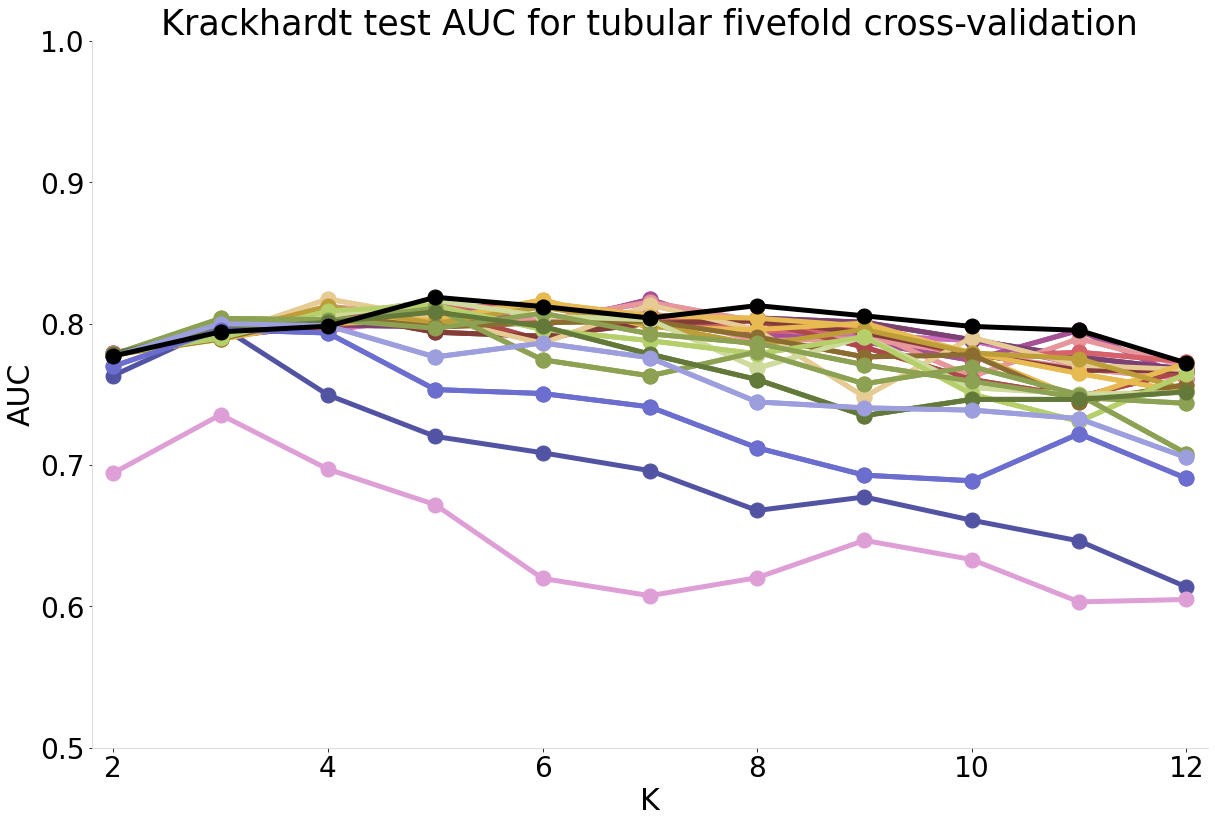

In [25]:
c_list = [1, 3, 6, 9, 12]
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.tab20b #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 25)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
for ell in range(2,23):
    col = colors[ell]
    axis.plot(range(2,13),avg_AUCs_krack_chunk[:, ell-1], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell-1]))
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)
    
for ell in range(22, 2, -1):
    col = colors[ell]
    axis.plot(range(2,13),avg_AUCs_krack_chunk[:, ell-1], lw = 5, marker='o', markersize= 15, c=col)
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)
axis.plot(range(2,13),avg_AUCs_krack_chunk[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

    
axis.set_ylim(0.5, 1)
axis.set_xlim(1.8, 12.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,13), avg_krack_ones_AUC_chunk, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')
#axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, .95),
          #ncol=5, fancybox=True, shadow=True)
axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Krackhardt test AUC for tubular fivefold cross-validation',fontsize=35)
#plt.savefig('krack_chunk_sweep.pdf', pad_inches=0.05)

## Figure 7
The test-AUC from the independent and tubular link prediction tasks in the Malaria multilayer network.

Text(0.5, 1.0, 'Malaria test AUC for independent fivefold cross-validation')

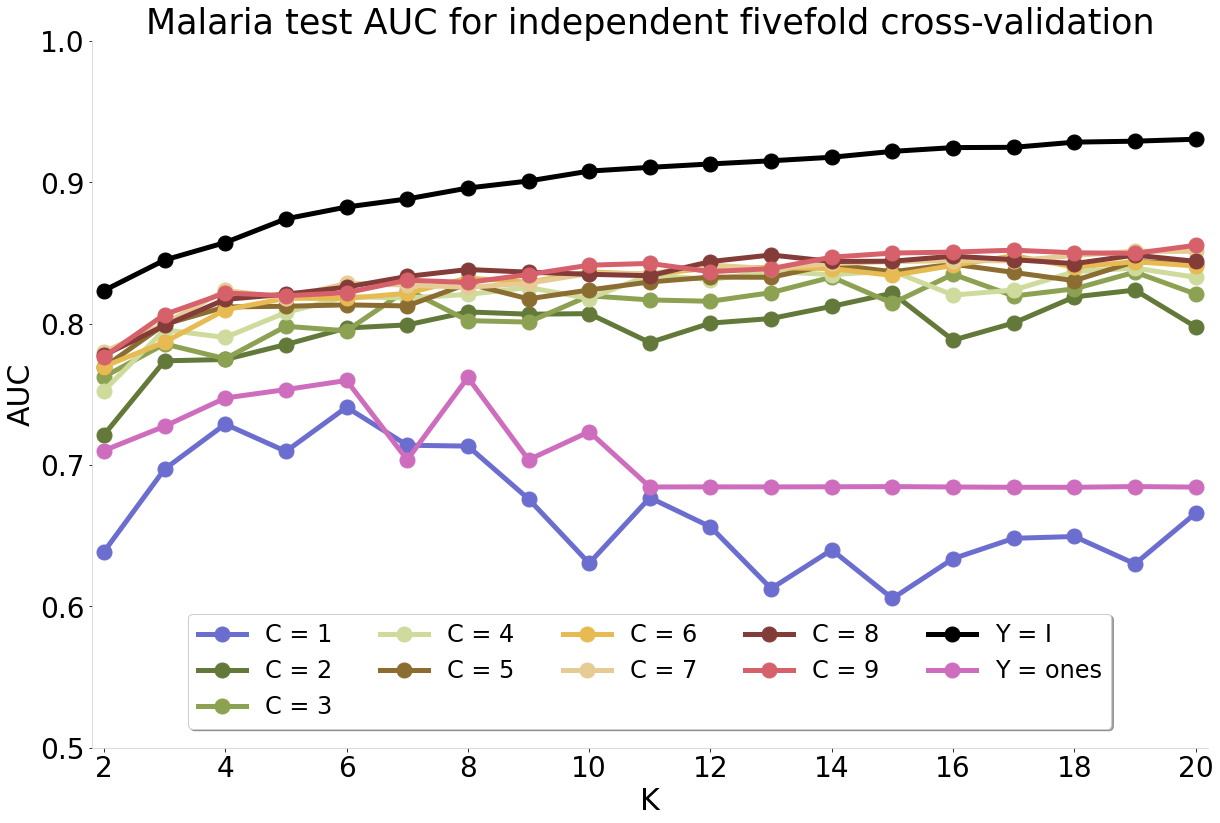

In [28]:
folder = data_path + 'data_malaria_PLOSCompBiology_2013/'
prefix = 'HVR_'
ext = '.txt'
malaria = np.zeros((9, 307, 307))
for k in range(1, 10):
    filename = folder + prefix + str(k) + ext
    for line in open(filename, 'r'):
        item = line.rstrip().split(",")
        i = int(item[0]) - 1; j = int(item[1])- 1;
        malaria[k - 1, i, j] = 1
        malaria[k - 1, j, i] = 1
avg_AUCs_mal_iid = np.load(data_path +'avg_AUCs_mal_iid.npy')
avg_KL_mal_iid = np.load(data_path +'avg_KL_mal_iid.npy')
avg_AUCs_mal_train_iid = np.load(data_path +'avg_AUCs_mal_train_iid.npy')
avg_KL_mal_train_iid = np.load(data_path +'avg_KL_mal_train_iid.npy')
avg_mal_ones_AUC = np.load(data_path +'avg_mal_ones_AUC.npy')
avg_mal_ones_KL = np.load(data_path +'avg_mal_ones_KL.npy')
avg_mal_ones_AUC_train = np.load(data_path +'avg_mal_ones_AUC_train.npy')
avg_mal_ones_KL_train = np.load(data_path +'avg_mal_ones_KL_train.npy')
c_list = [1, 3, 6, 9, 12]
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.tab20b #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 15)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9]
for ell in range(1,10):
    col = colors[ell+1]
    axis.plot(range(2,21),avg_AUCs_mal_iid[:, ell], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell]))
axis.plot(range(2,21),avg_AUCs_mal_iid[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

axis.set_ylim(0.5, 1)
axis.set_xlim(1.8, 20.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,21), avg_mal_ones_AUC, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')
axis.legend(fontsize = 24, loc='lower center', bbox_to_anchor=(0.5, .01),
          ncol=5, fancybox=True, shadow=True)
axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Malaria test AUC for independent fivefold cross-validation',fontsize=35)
#plt.savefig('mal_iid_sweep.pdf', pad_inches=0.05)

Text(0.5, 1.0, 'Malaria test AUC for tubular fivefold cross-validation')

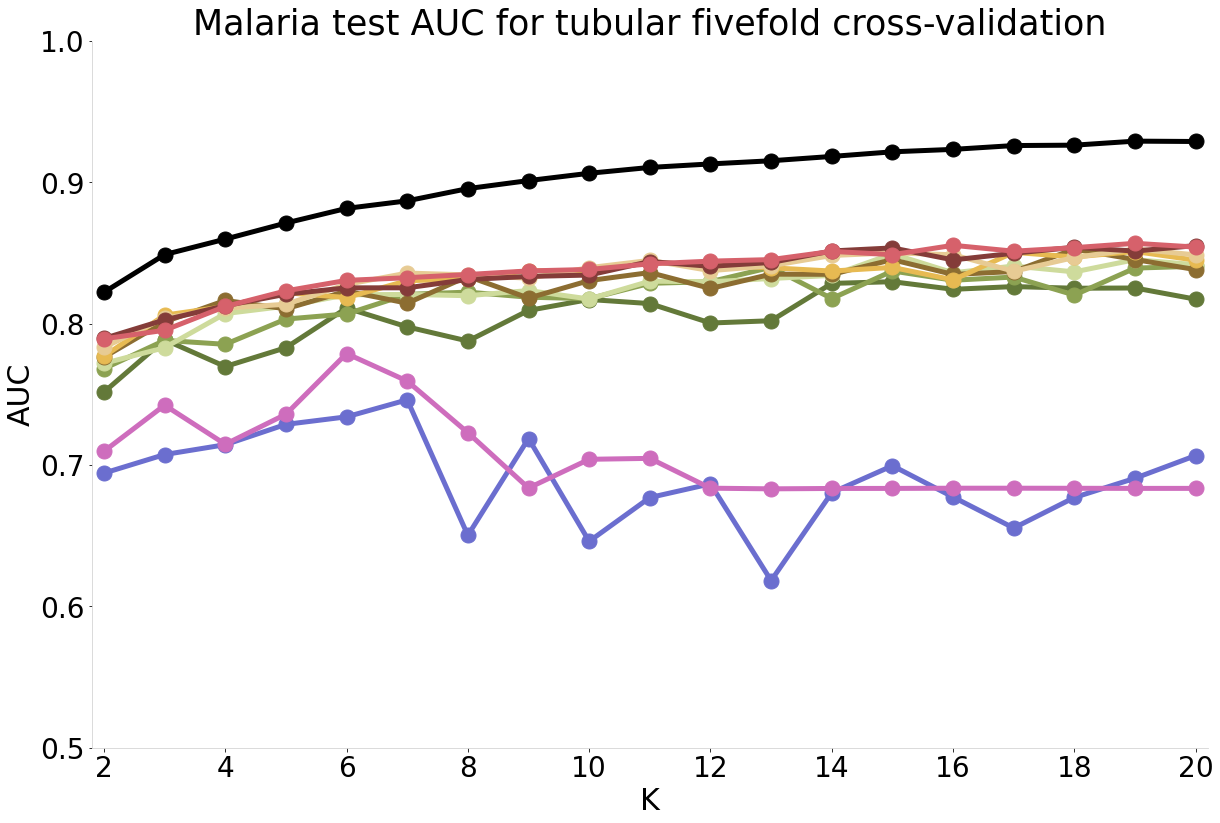

In [29]:
avg_AUCs_mal_chunk = np.load(data_path +'avg_AUCs_mal_chunk.npy')
avg_KL_mal_chunk = np.load(data_path +'avg_KL_mal_chunk.npy')
avg_AUCs_mal_train_chunk = np.load(data_path +'avg_AUCs_mal_train_chunk.npy')
avg_KL_mal_train_chunk = np.load(data_path +'avg_KL_mal_train_chunk.npy')
avg_mal_ones_AUC_chunk = np.load(data_path +'avg_mal_ones_AUC_chunk.npy')
avg_mal_ones_KL_chunk = np.load(data_path +'avg_mal_ones_KL_chunk.npy')
avg_mal_ones_AUC_train_chunk = np.load(data_path +'avg_mal_ones_AUC_train_chunk.npy')
avg_mal_ones_KL_train_chunk = np.load(data_path +'avg_mal_ones_KL_train_chunk.npy')
c_list = [1, 3, 6, 9, 12]
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.tab20b #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 15)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9]
for ell in range(1,10):
    col = colors[ell+1]
    axis.plot(range(2,21),avg_AUCs_mal_chunk[:, ell], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell]))
axis.plot(range(2,21),avg_AUCs_mal_chunk[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

    
axis.set_ylim(0.5, 1)
axis.set_xlim(1.8, 20.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,21), avg_mal_ones_AUC_chunk, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')
#axis.legend(fontsize = 24, loc='lower center', bbox_to_anchor=(0.5, .01),
          #ncol=5, fancybox=True, shadow=False)
axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Malaria test AUC for tubular fivefold cross-validation',fontsize=35)
#plt.savefig('mal_chunk_sweep.pdf', pad_inches=0.05)

## Figure 8 
The test-AUC from the independent and tubular link prediction tasks for the Village 0 multilayer network.

Text(0.5, 1.0, 'Village 0 test AUC for independent fivefold cross-validation')

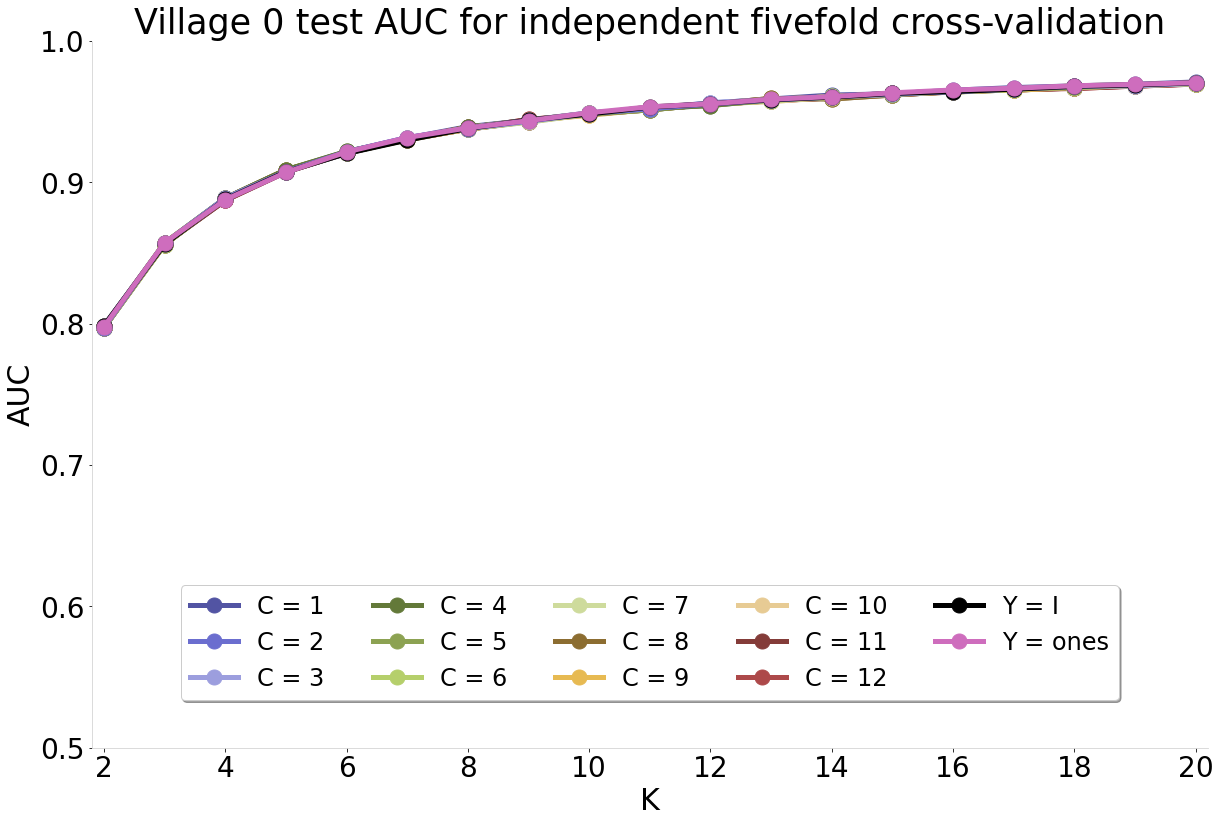

In [30]:
#---------- Import Data -------------#
BigVillsIND = np.load('BigVillsIND.npy', allow_pickle = True)
vill = 0
tensor = np.array([BigVillsIND[vill][1:][i] for i in range(len(BigVillsIND[0][1:]))])
#----------------------------------#
## Process the iid_RESULTS_Ala_50_Keq data

avg_AUCs_bvill_iid = np.load('avg_AUCs_bvill_iid.npy')
avg_KL_bvill_iid = np.load('avg_KL_bvill_iid.npy')
avg_AUCs_bvill_train_iid = np.load('avg_AUCs_bvill_train_iid.npy')
avg_KL_bvill_train_iid = np.load('avg_KL_bvill_train_iid.npy')

avg_bvill_ones_AUC = np.load('avg_bvill_ones_AUC.npy')
avg_bvill_ones_KL = np.load('avg_bvill_ones_KL.npy')
avg_bvill_ones_AUC_train = np.load('avg_bvill_ones_AUC_train.npy')
avg_bvill_ones_KL_train = np.load('avg_bvill_ones_KL_train.npy')

c_list = [1, 3, 6, 9, 12]
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.tab20b #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 19)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for ell in range(1,13):
    col = colors[ell]
    axis.plot(range(2,21),avg_AUCs_bvill_iid[:, ell], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell]))
for ell in range(12,1, -1):
    col = colors[ell]
    axis.plot(range(2,21),avg_AUCs_bvill_iid[:, ell], lw = 5, marker='o', markersize= 15, c=col)

axis.plot(range(2,21),avg_AUCs_bvill_iid[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

    
axis.set_ylim(0.5, 1)
axis.set_xlim(1.8, 20.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,21), avg_bvill_ones_AUC, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')


axis.legend(fontsize = 24, loc='lower center', bbox_to_anchor=(0.5, .05),
          ncol=5, fancybox=True, shadow=True)

axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Village 0 test AUC for independent fivefold cross-validation',fontsize=35)
#plt.savefig('bvill_sweep.pdf', pad_inches=0.05)

Text(0.5, 1.0, 'Village 0 test AUC for tubular fivefold cross-validation')

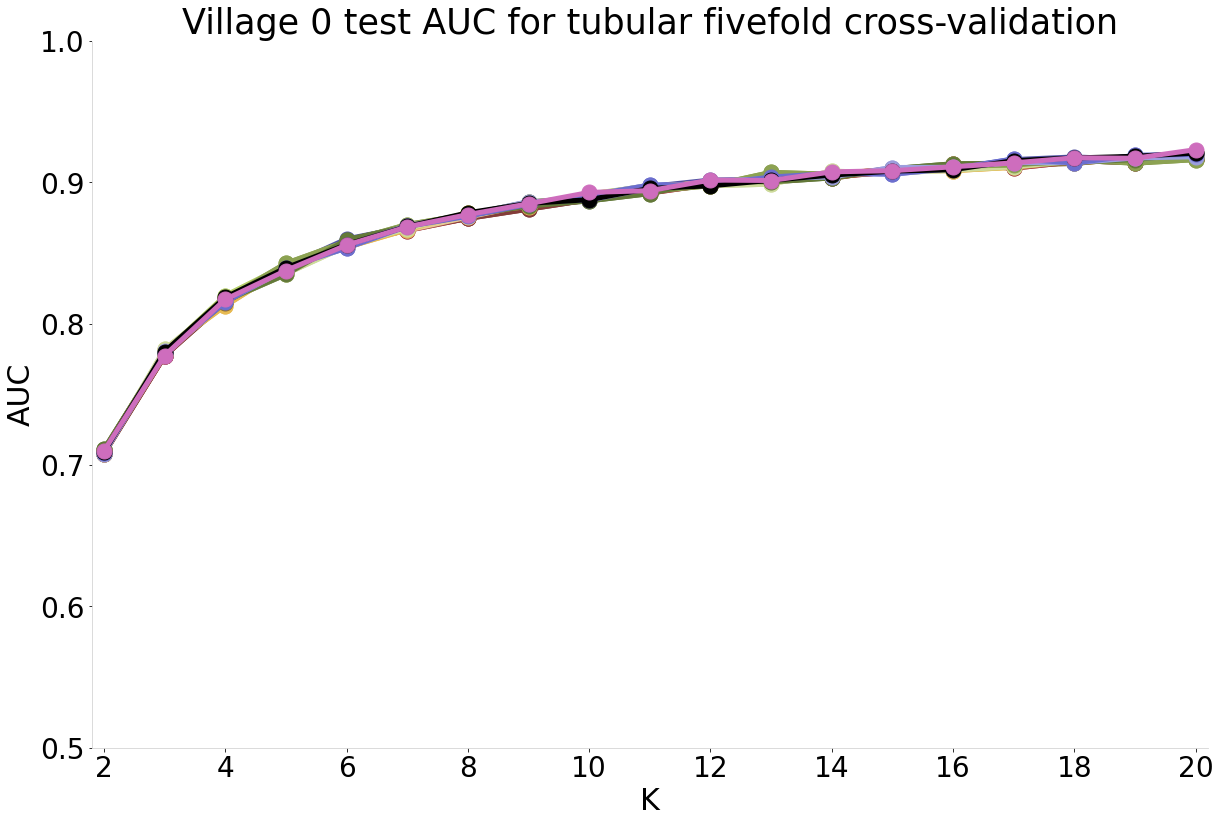

In [31]:
avg_AUCs_bvill_chunk = np.load('avg_AUCs_bvill_chunk.npy')
avg_KL_bvill_chunk = np.load('avg_KL_bvill_chunk.npy')
avg_AUCs_bvill_train_chunk = np.load('avg_AUCs_bvill_train_chunk.npy')
avg_KL_bvill_train_chunk = np.load('avg_KL_bvill_train_chunk.npy')
avg_bvill_ones_AUCchunk = np.load('avg_bvill_ones_AUCchunk.npy')
avg_bvill_ones_KLchunk = np.load('avg_bvill_ones_KLchunk.npy')
avg_bvill_ones_AUC_trainchunk = np.load('avg_bvill_ones_AUC_trainchunk.npy')
avg_bvill_ones_KL_trainchunk = np.load('avg_bvill_ones_KL_trainchunk.npy')
c_list = [1, 3, 6, 9, 12]
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.tab20b #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 19)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for ell in range(1,13):
    col = colors[ell]
    axis.plot(range(2,21),avg_AUCs_bvill_chunk[:, ell], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell]))
for ell in range(12,1, -1):
    col = colors[ell]
    axis.plot(range(2,21),avg_AUCs_bvill_chunk[:, ell], lw = 5, marker='o', markersize= 15, c=col)

axis.plot(range(2,21),avg_AUCs_bvill_chunk[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

    
axis.set_ylim(0.5, 1)
axis.set_xlim(1.8, 20.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,21), avg_bvill_ones_AUCchunk, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')

axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Village 0 test AUC for tubular fivefold cross-validation',fontsize=35)
#plt.savefig('bvill_sweep_chunk.pdf', pad_inches=0.05)

## Figure 9
Comparing the test-AUC from the layer redundant NNTuck to that from the layer independent NNTuck with K = 4 (left) and K = 10 (right) for 113 different village multilayer networks, the malaria network, the CSS, and the first synthetic network from Section 6.1.

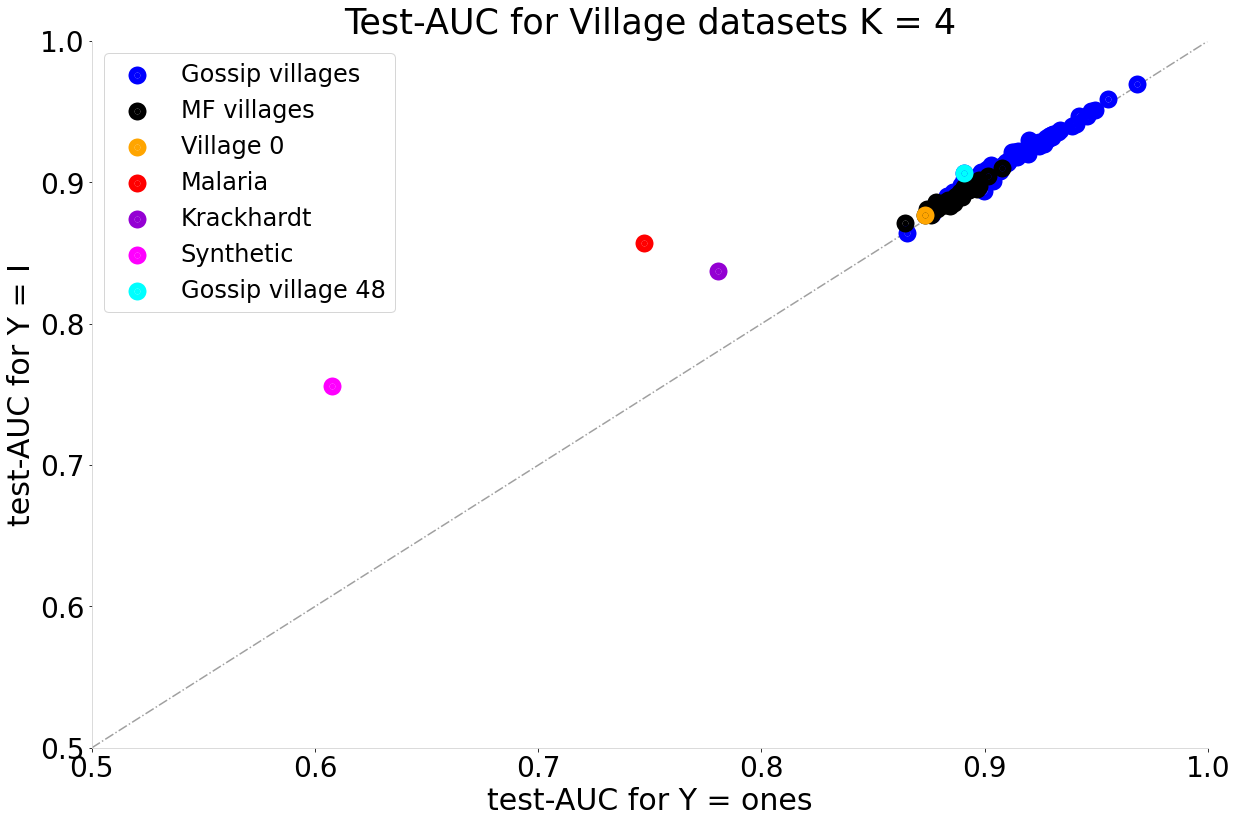

In [10]:
ceq6_AUCs_sur = np.load('iid_ban_ceq6_AUCs_sur.npy')
ceq12_AUCs_sur = np.load('iid_ban_ceq12_AUCs_sur.npy')
ceqid_AUCs_sur = np.load('iid_ban_ceqid_AUCs_sur.npy')
ceqones_AUCs_sur = np.load('iid_ban_ceqones_AUCs_sur.npy')

ceq6_AUCs = np.load('iid_ban_ceq6_AUCs.npy')
ceq12_AUCs = np.load('iid_ban_ceq12_AUCs.npy')
ceqid_AUCs = np.load('iid_ban_ceqid_AUCs.npy')
ceqones_AUCs = np.load('iid_ban_ceqones_AUCs.npy')

ceq6_AUCs_sur_keq10 = np.load('iid_ban_ceq6_AUCs_sur_keq10.npy')
ceq12_AUCs_sur_keq10 = np.load('iid_ban_ceq12_AUCs_sur_keq10.npy')
ceqid_AUCs_sur_keq10 = np.load('iid_ban_ceqid_AUCs_sur_keq10.npy')
ceqones_AUCs_sur_keq10 = np.load('iid_ban_ceqones_AUCs_sur_keq10.npy')

chunk_ceq6_AUCs_sur = np.load('chunk_ban_ceq6_AUCs_sur.npy')
chunk_ceq12_AUCs_sur = np.load('chunk_ban_ceq12_AUCs_sur.npy')
chunk_ceqid_AUCs_sur = np.load('chunk_ban_ceqid_AUCs_sur.npy')
chunk_ceqones_AUCs_sur = np.load('chunk_ban_ceqones_AUCs_sur.npy')

chunk_ceq6_AUCs_sur_keq10 = np.load('chunk_ban_ceq6_AUCs_sur_keq10.npy')
chunk_ceq12_AUCs_sur_keq10 = np.load('chunk_ban_ceq12_AUCs_sur_keq10.npy')
chunk_ceqid_AUCs_sur_keq10 = np.load('chunk_ban_ceqid_AUCs_sur_keq10.npy')
chunk_ceqones_AUCs_sur_keq10 = np.load('chunk_ban_ceqones_AUCs_sur_keq10.npy')

gossip_ceqones_AUCs = np.load('gossip_ceqones_AUCs.npy')
gossip_ceqid_AUCs = np.load('gossip_ceqid_AUCs.npy')
gossip_ceq7_AUCs = np.load('gossip_ceq7_AUCs.npy')
gossip_ceq3_AUCs = np.load('gossip_ceq3_AUCs.npy')

gossip_keq10_ceqones_AUCs = np.load('gossip_keq10_ceqones_AUCs.npy')
gossip_keq10_ceqid_AUCs = np.load('gossip_keq10_ceqid_AUCs.npy')
gossip_keq10_ceq7_AUCs = np.load('gossip_keq10_ceq7_AUCs.npy')
gossip_keq10_ceq3_AUCs = np.load('gossip_keq10_ceq3_AUCs.npy')

avg_mal_ones_AUC = np.load('avg_mal_ones_AUC.npy')
avg_mal_ones_KL = np.load('avg_mal_ones_KL.npy')
avg_mal_ones_AUC_train = np.load('avg_mal_ones_AUC_train.npy')
avg_mal_ones_KL_train = np.load('avg_mal_ones_KL_train.npy')

avg_AUCs_mal_iid = np.load('avg_AUCs_mal_iid.npy')
avg_KL_mal_iid = np.load('avg_KL_mal_iid.npy')
avg_AUCs_mal_train_iid = np.load('avg_AUCs_mal_train_iid.npy')
avg_KL_mal_train_iid = np.load('avg_KL_mal_train_iid.npy')

avg_AUCs_krack_iid = np.load('avg_AUCs_krack_iid.npy')
avg_KL_krack_iid = np.load('avg_KL_krack_iid.npy')
avg_AUCs_krack_train_iid = np.load('avg_AUCs_krack_train_iid.npy')
avg_KL_krack_train_iid = np.load('avg_KL_krack_train_iid.npy')

avg_krack_ones_AUC = np.load('avg_krack_ones_AUC.npy')
avg_krack_ones_KL = np.load('avg_krack_ones_KL.npy')
avg_krack_ones_AUC_train = np.load('avg_krack_ones_AUC_train.npy')
avg_krack_ones_KL_train = np.load('avg_krack_ones_KL_train.npy')

avg_AUCs_Syn_iid = np.load('avg_AUCs_Syn_iid.npy')
avg_KL_Syn_iid = np.load('avg_KL_Syn_iid.npy')
avg_AUCs_Syn_train_iid = np.load('avg_AUCs_Syn_train_iid.npy')
avg_KL_Syn_train_iid = np.load('avg_KL_Syn_train_iid.npy')

avg_Syn_ones_AUC = np.load('avg_Syn_ones_AUC.npy')
avg_Syn_ones_KL = np.load('avg_Syn_ones_KL.npy')
avg_Syn_ones_AUC_train = np.load('avg_Syn_ones_AUC_train.npy')
avg_Syn_ones_KL_train = np.load('avg_Syn_ones_KL_train.npy')

f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
axis.scatter(gossip_ceqones_AUCs, gossip_ceqid_AUCs, c = 'blue', lw = 12, label = 'Gossip villages')

axis.scatter(ceqones_AUCs_sur, ceqid_AUCs_sur, c = 'k', lw = 12, label = 'MF villages')
axis.scatter(ceqones_AUCs_sur[0], ceqid_AUCs_sur[0], c = 'orange', lw = 12, label = 'Village 0')
axis.scatter(avg_mal_ones_AUC[2], avg_AUCs_mal_iid[2,0], c = 'red', lw = 12, label = 'Malaria')
axis.scatter(avg_krack_ones_AUC[2], avg_AUCs_krack_iid[2,0], c = 'darkviolet', lw = 12, label = 'Krackhardt')
axis.scatter(avg_Syn_ones_AUC[2], avg_AUCs_Syn_iid[2,0], c = 'fuchsia', lw = 12, label = 'Synthetic')

axis.scatter(gossip_ceqones_AUCs[21], gossip_ceqid_AUCs[48], c = 'cyan', lw = 12, label = 'Gossip village 48')
axis.plot((0.5, 1), (0.5, 1), '-.', alpha=0.75, zorder=0, c = 'grey')
axis.set_xlim(0.5, 1)
axis.set_ylim(0.5, 1)
axis.set_ylabel('test-AUC for Y = I', fontsize = 30)
axis.set_xlabel('test-AUC for Y = ones', fontsize = 30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Test-AUC for Village datasets K = 4', fontsize = 35)
axis.legend(fontsize = 24)
#f.savefig( 'village_I_ones_k4.pdf')

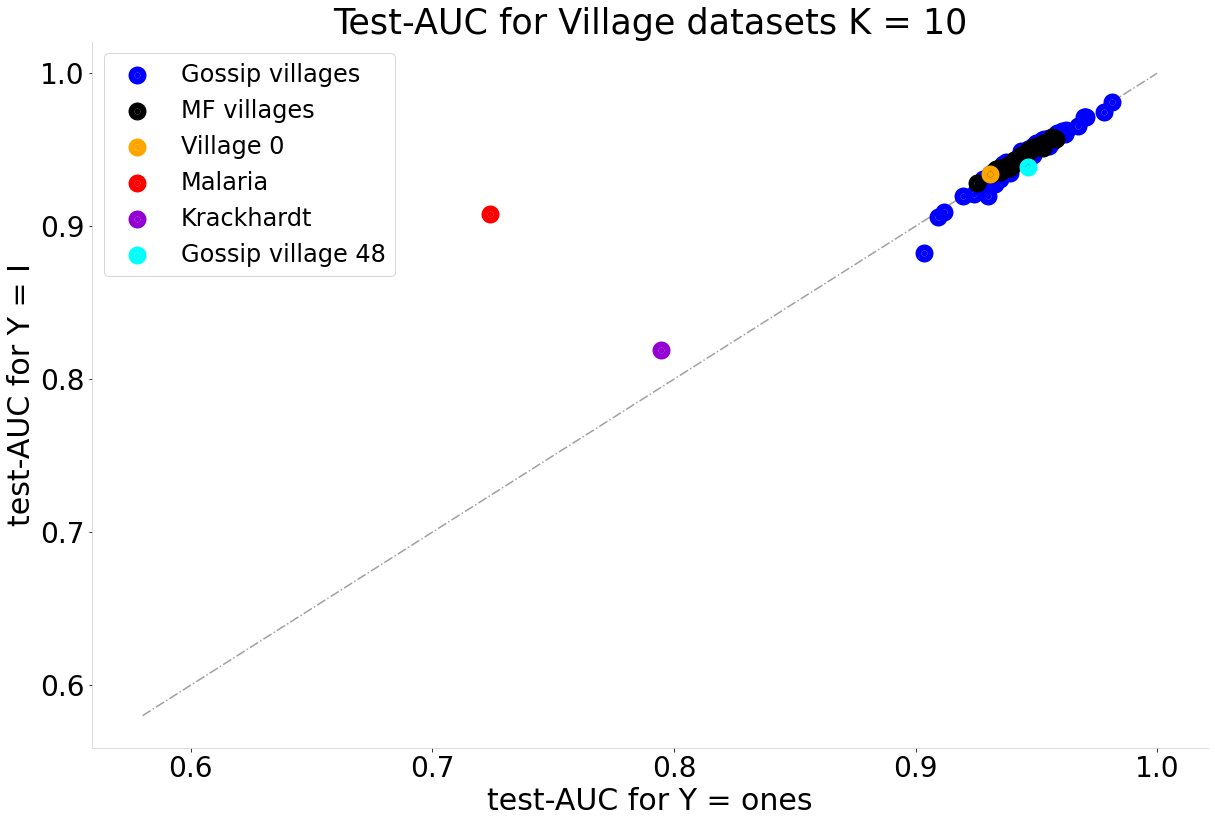

In [11]:
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
axis.scatter(gossip_keq10_ceqones_AUCs, gossip_keq10_ceqid_AUCs, c = 'blue', lw = 12, label = 'Gossip villages')
axis.scatter(ceqones_AUCs_sur_keq10, ceqid_AUCs_sur_keq10, c = 'k', lw = 12, label = 'MF villages')
#axis.scatter(avg_Ala_ones_AUC[8], avg_AUCs_Ala_iid[8,0], c = 'green', lw = 12, label = 'Alakapuram')
#axis.scatter(avg_Ten_ones_AUC[8], avg_AUCs_Ten_iid[8,0], c = 'orange', lw = 12, label = 'Tenpatti')
axis.scatter(ceqones_AUCs_sur_keq10[0], ceqid_AUCs_sur_keq10[0], c = 'orange', lw = 12, label = 'Village 0')
axis.scatter(avg_mal_ones_AUC[8], avg_AUCs_mal_iid[8,0], c = 'red', lw = 12, label = 'Malaria')
axis.scatter(avg_krack_ones_AUC[8], avg_AUCs_krack_iid[8,0], c = 'darkviolet', lw = 12, label = 'Krackhardt')
axis.plot((0.58, 1), (0.58, 1), '-.', alpha=0.75, zorder=0, c = 'grey')
axis.scatter(gossip_keq10_ceqones_AUCs[21], gossip_keq10_ceqid_AUCs[48], c = 'cyan', lw = 12, label = 'Gossip village 48')
axis.set_ylabel('test-AUC for Y = I', fontsize = 30)
axis.set_xlabel('test-AUC for Y = ones', fontsize = 30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Test-AUC for Village datasets K = 10', fontsize = 35)
axis.legend(fontsize = 24)
f.savefig( 'village_I_ones_k10.pdf')